## <center> **Latency Arbitrage**  

This notebook implements a latency arbitrage, identifying significant trades on Binance and executes trades on HyperLiquid based on order book imbalance signals.

### Key Features
1. **Slippage Modeling**
   - Order book walking with latency simulation
   - Transaction cost modeling
   - Dynamic liquidity impact estimation

2. **Statistical Significance Testing**
   - Bootstrap analysis for confidence intervals
   - Power analysis for sample size estimation

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import logging
from collections import defaultdict
from tqdm import tqdm
from statsmodels.stats.power import TTestPower
from scipy import stats
import matplotlib.dates as mdates
from scipy.stats import ttest_1samp
from typing import List, Dict, Tuple, Any, Optional, Union

# Auto-reload external module changes without restarting
%load_ext autoreload
%autoreload 2

# Import our code
import data_loader as dl
import utils as ref

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# For cleaner pandas output
pd.set_option('expand_frame_repr', False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Strategy Overview

The idea is that large trades on Binance may cause short-term price changes that propagate to HyperLiquid. By detecting these "significant trades" quickly, we can enter positions on HyperLiquid, factoring in order book imbalance for additional confirmation, and exit once we achieve a certain profit threshold relative to fees.

- We define *significant* trades on Binance as those above a very high
  volume, to capture only the largest moves.
- On HyperLiquid, we watch the order book imbalance at the time we get
  the signal. If it supports going long, we take a buy position; if it supports going
  short, we take a sell position.
- The backtest simulates realistic conditions, including:
     * Slippage from walking the order book
     * Latency, which reduces available liquidity
     * Taker/maker fees
     * A maximum holding period, after which we exit regardless

The code also includes statistical significance tests, such as:
 - Bootstrap for confidence intervals
 - Power analysis to estimate how many trades we need to achieve significance

In [25]:
# Parameters for data retrieval
SYMBOL = 'OMNI'
START_MONTH = 5
END_MONTH = 12
YEAR = 2024

In [26]:
# Load Binance trades (signal data)
binance_trades = dl.load_binance_trades_monthly(
    SYMBOL, 
    YEAR, 
    START_MONTH, 
    END_MONTH,
    file_extension='parquet'
)

2025-05-04 15:39:48,809 - INFO - Loading Binance trades from cache: cache/binance_OMNI_2024_5_12.pkl


In [27]:
# Load Binance trades (signal data)
binance_trades = dl.load_binance_trades_monthly(
    SYMBOL, 
    YEAR, 
    START_MONTH, 
    END_MONTH
)

# Load processed LOB data for HyperLiquid (target data)
hl_book_resampled = dl.load_minimal_lob_data(SYMBOL, year=2024, start_month=START_MONTH, end_month=END_MONTH, base_path='../data/processed_lob_data')

print(f"Binance trades shape: {binance_trades.shape}")
print(f"LOB data shape: {hl_book_resampled.shape}")

# Display small sample
print("\nBinance trades sample:")
print(binance_trades.head())

print("\nLOB data sample:")
print(hl_book_resampled)

2025-05-04 15:39:48,992 - INFO - Loading Binance trades from cache: cache/binance_OMNI_2024_5_12.pkl
2025-05-04 15:39:49,076 - INFO - Loading monthly LOB file (1/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202405.parquet.gz
2025-05-04 15:39:49,304 - INFO - Loading monthly LOB file (2/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202406.parquet.gz
2025-05-04 15:39:49,500 - INFO - Loading monthly LOB file (3/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202407.parquet.gz
2025-05-04 15:39:49,692 - INFO - Loading monthly LOB file (4/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202408.parquet.gz
2025-05-04 15:39:49,867 - INFO - Loading monthly LOB file (5/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202409.parquet.gz
2025-05-04 15:39:50,051 - INFO - Loading monthly LOB file (6/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202410.parquet.gz
2025-05-04 15:39:50,260 - INFO - Loading monthly LOB file (7/8): ../data/processed_lob_data\OMNI\OMNI_LOB_202411.parquet.gz
2025-05-04 15:39:50,482 - INFO 

Binance trades shape: (4632653, 6)
LOB data shape: (34635289, 7)

Binance trades sample:
                         trade_id  price    qty  quote_qty  is_buyer_maker  is_best_match
timestamp                                                                                
2024-05-01 00:00:19.244   2676173  18.29   0.39     7.1331           False           True
2024-05-01 00:00:25.779   2676185  18.26  35.27   644.0302            True           True
2024-05-01 00:00:25.784   2676188  18.28   1.31    23.9468           False           True
2024-05-01 00:00:25.785   2676189  18.28   1.31    23.9468           False           True
2024-05-01 00:00:25.790   2676190  18.27   1.31    23.9337           False           True

LOB data sample:
                         BidPrice_1   BidSize_1  AskPrice_1   AskSize_1   MidPrice  Imbalance  Microprice
time                                                                                                     
2024-05-01 00:00:06.441   18.292999  186.630005    

### **Significant Trade Identification and Alignment**

- Filter down to a relevant time range on Binance
- Identify trades above a certain quantile threshold
- Align these "significant trades" to the nearest HyperLiquid LOB snapshot, applying a time offset

In [28]:
# Filter Binance trades to our target date range
if not binance_trades.empty:
    start_t = pd.Timestamp('2024-05-01')
    end_t = pd.Timestamp('2024-12-20 23:59:59')
    binance_trades_rs = binance_trades.loc[start_t:end_t]

    # We now show how to use rolling threshold
    sig_trades = dl.identify_significant_trades(
       binance_trades_rs, use_rolling_threshold=True, rolling_window='7d', rolling_multiplier=25.0
    )
else:
    sig_trades = pd.DataFrame()

# Align trades with LOB snapshots
if not sig_trades.empty and not hl_book_resampled.empty:
    sig_trades_aligned = dl.align_trades_to_lob(sig_trades, hl_book_resampled, time_offset_ms=100)
else:
    sig_trades_aligned = pd.DataFrame()

print(f"Number of significant trades identified: {len(sig_trades)}")
print(f"Number of significant trades aligned to LOB: {len(sig_trades_aligned)}")
    

print(f"Number of significant trades identified: {len(sig_trades)}")
print(f"Number of significant trades aligned to LOB: {len(sig_trades_aligned)}")

2025-05-04 15:39:54,982 - INFO - Identified 920 significant trades via rolling threshold approach.
2025-05-04 15:39:54,993 - INFO - Loading aligned trades from cache: cache/aligned_trades_-9049700512920501897.pkl


Number of significant trades identified: 920
Number of significant trades aligned to LOB: 920
Number of significant trades identified: 920
Number of significant trades aligned to LOB: 920


## <center> **Backtest**

We configure base parameters for the backtest, including fees, size constraints, maximum holding, slippage settings, etc. Then we run the backtest on our aligned trades and examine the performance metrics.

Running backtest...


--- Backtest Summary ---
Total Profit: 206.0727
Successful Trades: 83
Failed Trades: 25
Win Rate: 76.85%
Skipped: 806
Avg Entry Slippage: 0
Avg Exit Slippage: 0
Avg Profit Per Trade: 1.9081
Profit Std Dev: 3.8319
Max Profit: 26.9950
Min Profit: -6.1761
Total Trades: 108
Max Drawdown: 0.0006
Sharpe Ratio: 0.4979
Annualized Sharpe: 6.5070
Sortino Ratio: 1.5964


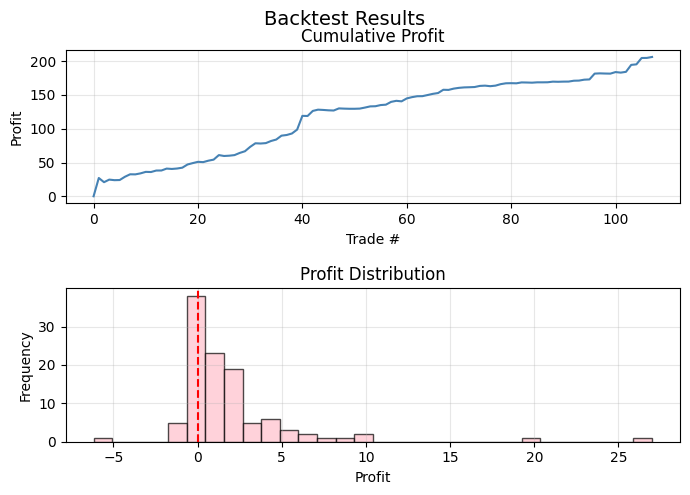

In [31]:
base_params = {
    'taker_fee': 0.00039,
    'maker_fee': 0.00010,
    'fee_multiple': 2,
    'capital': 10_000,
    'min_size': 10,
    'max_size': 100,
    'imb_threshold_long': -0.70,
    'imb_threshold_short': 0.70,
    'use_microprice': True,
    'use_trailing_stop': True,
    'trailing_activation_bps': 2,
    'trailing_distance_bps': 5,
    'max_risk_pct': 0.50,
    'simulate_slippage': True,
    'slippage_factor': 1.0,
    'mean_latency_ms': 50,
    'std_dev_latency_ms': 10
}

if not sig_trades_aligned.empty and not hl_book_resampled.empty:
    print("Running backtest...\n")
    
    summary_with_slippage, results = ref.backtest(
        sig_trades_aligned,
        hl_book_resampled,
        **base_params
    )
    
    # Print the summary metrics
    print("\n--- Backtest Summary ---")
    for k, v in summary_with_slippage.items():
        if k == 'Win Rate':
            print(f"{k}: {v:.2%}")
        elif isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")
    
    # If we have trade-by-trade data, create a results DataFrame and plot
    if results:
        df_results_with = pd.DataFrame(results)
        df_results_with['cumulative_profit'] = df_results_with['profit'].cumsum()
        
        # Plot the results: cumulative PnL, distribution of trades, etc.
        ref.plot_results(df_results_with)
        
        # Also store returns = profit / capital
        df_results_with['return'] = df_results_with['profit'] / base_params['capital']
else:
    print("Insufficient data for a backtest.")

## <center> **Statistical Significance Analysis**

We use  
* **Block bootstrap** – to build a confidence interval for the mean return.  
* **Power analysis** – to estimate how many trades we need for a reliable test.

### <center> **Why a Block Bootstrap?**

Classical tests assume each trade’s return is IID and roughly Normal. Latency-arb P&L violates this because:

* **Clustering/autocorrelation** – trades arrive in bursts after large prints, so nearby returns are dependent.
* **Regime shifts** – intraday volatility changes; news spikes create 10 $\times$ outliers.
* **Small sample** – with only $\approx$ 100 trades, large-$n$ (asymptotic normal) theory is shaky.

A block bootstrap keeps those short-run dependencies intact while estimating sampling uncertainty.

#### <center> **How it works**
1. **Bundle trades into blocks.**  
   We cut the return series into consecutive 5-trade chunks, *blocks*.  
2. **Resample blocks with replacement.**  
   We randomly pick blocks, with duplicates allowed, and glue them back-to-back until we rebuild a series of the original length.  
   *Blocks preserve the local dependence inside each burst.*  
3. **Compute the statistic.**  
   For each resampled series we record the average return.  
4. **Repeat thousands of times.**  
   The collection of these "what-if" averages gives  
   * an **$(1 - \alpha)$ CI** – the central 95 % of bootstrap means, and  
   * a **p-value** – the fraction of bootstrap means $\le 0$ for our one-sided test.

Because the bootstrap respects serial correlation, heavy tails, and heteroskedasticity, it gives a more trustworthy answer to:

> *Is our average edge still positive once we acknowledge trades come in correlated bursts?*


--- Bootstrap Analysis ---
Mean return          : 0.000191
95 % CI (percentile) : [0.000121, 0.000248]
One-sided p-value    : 0.000000


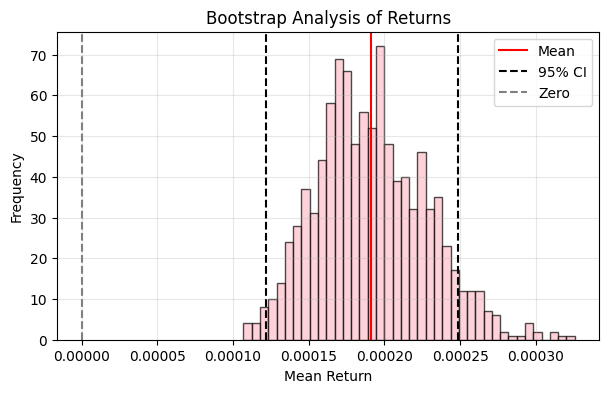

Required Sample Size for 80% Power: 34 trades
Current Sample: 108 trades (100.0% of required)


In [32]:
if 'df_results_with' in locals() and not df_results_with.empty:
    returns = df_results_with['return'].values
    
    # Bootstrap analysis
    mean_ret, (ci_low, ci_high), p_val = ref.bootstrap_returns(
        returns       = returns,
        iterations    = 50_000,
        confidence    = 0.95,
        block_size    = 5,        # keep ≥ typical trade cluster length
        side          = "greater" # H1: edge > 0
    )
    
    print("\n--- Bootstrap Analysis ---")
    print(f"Mean return          : {mean_ret:.6f}")
    print(f"95 % CI (percentile) : [{ci_low:.6f}, {ci_high:.6f}]")
    print(f"One-sided p-value    : {p_val:.6f}")
    
    ref.plot_bootstrap_analysis(
        returns,
        bootstrap_mean=mean_ret,
        conf_interval=(ci_low, ci_high),
        title="Bootstrap Analysis of Returns"
    )
    
    # Power analysis
    required_sample = ref.calculate_power_sample_size(returns)
    print(f"Required Sample Size for 80% Power: {required_sample:.0f} trades")
    if np.isfinite(required_sample):
        current_percentage = (len(returns) / required_sample) * 100
        current_percentage = min(current_percentage, 100)
        print(f"Current Sample: {len(returns)} trades ({current_percentage:.1f}% of required)")
    else:
        print("Insufficient or invalid data for a power calculation.")